In [6]:
%pip install keras pandas scikit-learn tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/0f/a5/89a9bdae9f241cad167edb6c890ef2b4c842c5ae81058a2fbfd702dba9bf/tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488bb02e58694cd79d61369e85900/flatbuffers-24.3.25-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38461d751cd1a0c3a6ae84346796a5758123f3ed97a1b121dfbf4f3/gast-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for google-pasta>=0.1.1 from https://files.pythonhosted.org/packages/a3/de/c648e

In [64]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# load datasets
amazon_data = pd.read_csv('/Users/justinhuynh/Desktop/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['sentence', 'label'])
imdb_data = pd.read_csv('/Users/justinhuynh/Desktop/imdb_labelled.txt', delimiter='\t', header=None, names=['sentence', 'label'])
yelp_data = pd.read_csv('/Users/justinhuynh/Desktop/yelp_labelled.txt', delimiter='\t', header=None, names=['sentence', 'label'])

In [65]:
# combine all 3 datasets into 1
combined_data = pd.concat([amazon_data, imdb_data, yelp_data])

In [66]:
# initialize tokenizer
sentences = combined_data['sentence'].values
labels = combined_data['label'].values

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [67]:
# pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50, padding='pre')

print(padded_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   27   50    5   58  118   12   72    7  371    6   11   66   11
    1  188  579    3   77   62    4 2267]


In [68]:
# initialize the model
model = Sequential()

# add final output layer
model.add(Dense(1, activation='sigmoid'))

In [69]:
# split the data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# check the shape of the data
print(X_train.shape, X_val.shape, X_test.shape)

(1923, 50) (412, 50) (413, 50)


In [70]:
# combine the padded sequences and labels into a DataFrame
prepared_data = pd.DataFrame(padded_sequences)

# add the labels as a new column
prepared_data['label'] = labels

# save the prepared dataset to a csv file
prepared_data.to_csv('prepared_sentiment_data_d213_tas2.csv', index=False)

In [71]:
# define the model architecture
model = Sequential()

# add embedding layer (input_dim corresponds to vocabulary size, output_dim is embedding size)
model.add(Embedding(input_dim=10000, output_dim=100))

# flatten the embedding output to feed into Dense layers
model.add(Flatten())

# add a dense layer
model.add(Dense(128, activation='relu'))

# add the final output layer (sigmoid for binary classification)
model.add(Dense(1, activation='sigmoid'))

# build the model (since input shape is known, it needs to be explicitly built)
model.build(input_shape=(None, 50))

# print the model summary
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,640,257 (6.26 MB)

 Trainable params: 1,640,257 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# compile the model before fitting it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping with patience of 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5086 - loss: 0.6960 - val_accuracy: 0.6165 - val_loss: 0.6675
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8293 - loss: 0.5331 - val_accuracy: 0.7646 - val_loss: 0.5163
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9697 - loss: 0.1338 - val_accuracy: 0.7379 - val_loss: 0.6092
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9977 - loss: 0.0343 - val_accuracy: 0.7743 - val_loss: 0.5677
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9978 - loss: 0.0139 - val_accuracy: 0.7597 - val_loss: 0.6352


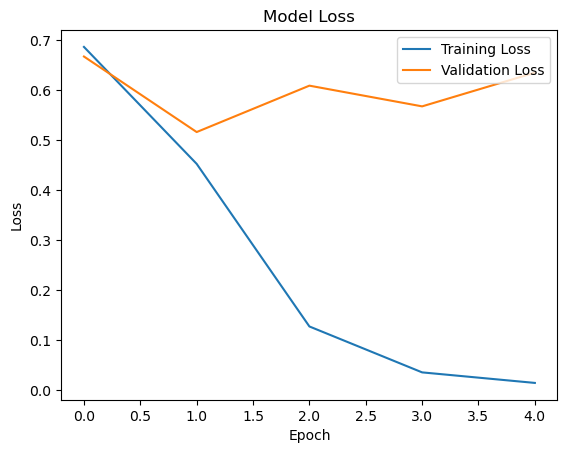

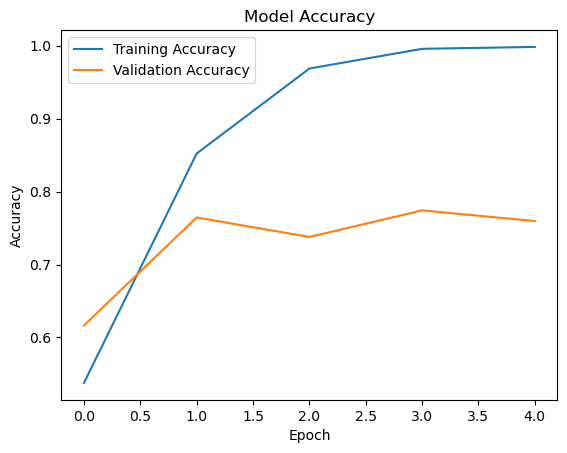

In [73]:
# plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [74]:
# evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# print test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7372 - loss: 0.5203 
Test Accuracy: 75.79%


In [77]:
# save the trained model to a file
model.save('sentiment_analysis_model_d213_task2.keras')